## Primero cargamos las librerias que vamos a usar 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import math
from scipy.signal import find_peaks
import random

### Cargamos los datos: 

In [5]:
Destatico = pd.read_csv(
    'https://raw.githubusercontent.com/KenetC/myt_verano24/main/DatosTaller3/datosEstatico',
    delimiter="\t",
    header=None
)

In [289]:
url = 'https://raw.githubusercontent.com/KenetC/myt_verano24/main/DatosTaller3/medicion'
Ms = np.zeros(10) # masas
T = np.zeros(10) # periodos
err = np.zeros(10)
for i in range(1,11): 
    URL = url+str(i)
    df = pd.read_csv(
      URL,  # el primer archivo,
      skiprows=3,  # que ignore las primeras 3 filas
      delimiter="\t",  # separador Tab
      decimal=",",  # coma decimal
      )
    data = df.values
    # masas 
    m = data[0,0] # en gramos 
    Ms[i-1] = m/1000 # en Kg
    
    # Datos de la fuerza y tiempo 
    D = data[1:]
    t = D[1200:5000, 0]  # tiempo [s]
    v = D[1200:5000, 1]  # fuerza en N = Kg m/s2
    
    # Hallamos los picos 
    dist = 80 #distancia entre picos
    altura = 2 # altura minima de los picos

    pos_picos,_ = find_peaks(v,distance=dist, height = altura) #extra posiciones de los picos
    tiempo_picos = t[pos_picos] #evaluo las posiciones en los tiempos
    fuerza_picos = v[pos_picos] #evaluo las posiciones en las fuerzas
    #plt.plot(t,v)
    #plt.plot(tiempo_picos,fuerza_picos,'.')
    #plt.show()
    #w0 = 2*np.pi/T
    #print('MASA: ', m)
    #print('MEDIA:', np.mean(np.diff(tiempo_picos)))
    #print('DESVIO:', np.std(np.diff(tiempo_picos)))
    #print(f"Periodo = {T:.4f}, W0 = {w0:.4f}")
    T[i-1] = np.mean(np.diff(tiempo_picos))
    err[i-1] = np.std(np.diff(tiempo_picos))
    
# incerteza de la masa (en g) es 0.1 
dMs = (0.1/1000) *np.ones(10)
Ms += 135.2/1000
# Sucede lo mismo que hecho en el ajuste del talle 2 luego 
dT = np.sqrt((err/np.sqrt(10))**2 + 0.007**2) #(0.007)*np.ones(10)

Definicion de funciones: 

$$\Delta T = \sqrt{(\frac{\sigma_{i}}{\sqrt{10}})^2 + err_{inst}^2}=\sqrt{(\frac{\sigma_{i}}{\sqrt{10}})^2 + 0.007^2}$$

In [3]:
# y = datos. f = ajuste. sd = errores del ajuste. k = cantidad de parametros
def reduced_chi_sq(y, f, sd, k):
    # https://en.wikipedia.org/wiki/Reduced_chi-squared_statistic
    return np.sum(((y-f)/sd)**2) / (len(y)-k)

def r_sq(y, f):
    # https://en.wikipedia.org/wiki/Coefficient_of_determination
    rss = np.sum((y-f)**2)
    tss = np.sum((y-np.mean(y))**2)
    return 1 - rss/tss

def Residuos(y, f):
    residuos = y-f
    return residuos

### Primera Parte: Determinacion de la constante elastica k 

### Metodo Estatico 

Tenemos la siguiente ecuacion que relaciona el punto de equilibrio $ x_{eq} $, posicion inicial $l_0$ y la constante $k$, junto a la masa $m$ donde podremos usar lo aprendido en el taller2 para estimar el valor de $k$
$$ x_{eq}= \frac{mg}{k} + l_0$$
$$ x_{eq}-l_0= \frac{mg}{k}$$
$$ x_{eq}-l_0= \underbrace{mg}_{X} \underbrace{\frac{1}{k}}_{\alpha}$$

$$ \Delta X = \sqrt{(g\Delta m)^2 + (m\Delta g)^2}$$ 

Por el momento vamos a usar las estimaciones de la gravedad y su error, obtenidas en el tp anterior

$$ \Delta k = \frac{1}{a^2} \Delta a  $$

Definimos las variables:  

In [151]:
l0 = 35 # cm 
xeq = (Destatico.values[:,1] - l0)/100 # en metros 
dl = 0.1/100 # error de apreciacion de xeq y l0 en metros 
m = Destatico.values[:,0] / 1000  # en Kg 
dm = 0.1/1000 # error de apreciacion de las masas
g = 9.81 # m/s2
#g= 0.038221086429790234
X = m * g # en
dX = np.sqrt((g*dm)**2 ) # + (m*dg)**2

In [152]:
Destatico.values[:,1]/100

array([0.429, 0.449, 0.424, 0.437, 0.455, 0.474, 0.443, 0.433, 0.451,
       0.483])

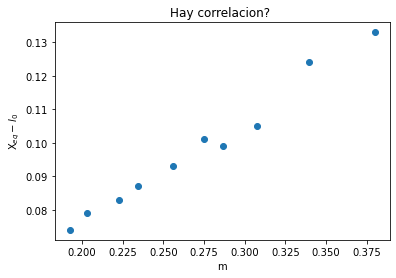

In [153]:
plt.scatter(m,xeq)
plt.xlabel('m')
plt.ylabel('X$_{eq} - l_0$')
#plt.xlim(0,400)
#plt.ylim(0,13)
plt.title('Hay correlacion? ')
plt.show()

In [154]:
def Xeq(x,a): 
    return a*x 

popt, pcov = curve_fit(Xeq,X,xeq)

a = popt[0]
da = np.sqrt(pcov[0,0])

print('a =',  a)
#print('b =',  b)
print('da =', da)

a = 0.036734034949452044
da = 0.0004668304248229239


In [155]:
k = 1/a
dk = 1/a**2 * da
print('k =',k)
print('dk =',dk)

k = 27.222710529242224
dk = 0.34595680922841826


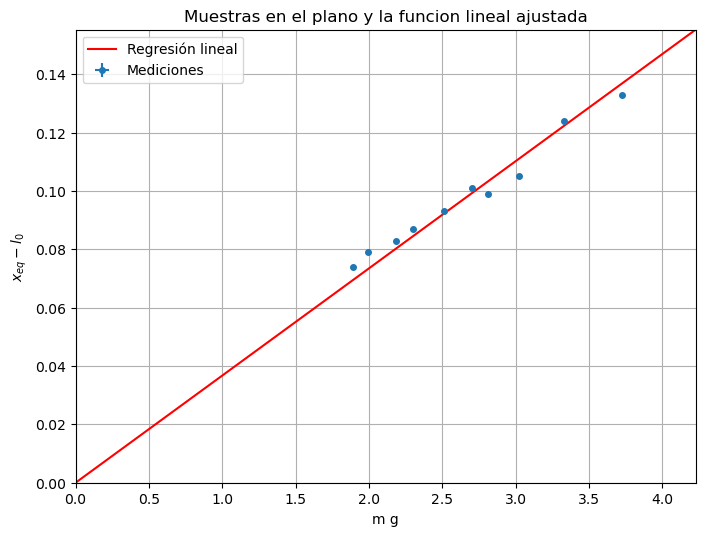

In [163]:
x_min = 0 #min(X) - 100
x_max = max(X) +0.5

axis = np.linspace(x_min, x_max, 100)

plt.figure(figsize=(8,6),dpi=100)
plt.errorbar(X, xeq, xerr=dX,yerr=0.0001 ,marker='o',  markersize=4, linestyle="None", label="Mediciones")
plt.plot(axis, Xeq(axis, a), 'r-', label="Regresión lineal")

plt.axis([x_min, x_max, Xeq(x_min, *popt), Xeq(x_max, *popt)])
plt.title('Muestras en el plano y la funcion lineal ajustada')
plt.xlabel('m g')
plt.ylabel('$x_{eq} - l_0$')

plt.grid(True)
plt.legend()
plt.show()

### Metodo Dinamico 

Movimiento Armonico Simple, tenemos la siguiente ecuacion diferencial 
$$ x^{''} + w^{2}_0 x = w^{2}_0  x_{eq}$$
con solucion 
$$ x(t) = A cos(w_0 + \phi) + x_{eq}  \hspace{1cm} w_0 = \sqrt{\frac{k}{m}} = \frac{2 \pi}{T} $$

Vamos a estimar la frecuencia de oscilacion a travez del periodo 
$$ w_0 = \sqrt{\frac{k}{m}} = \frac{2 \pi}{T}  \hspace{1cm}[1] $$ 

Donde la ecuacion de la fuerza es 
$$ F(t) = A cos(w_0 + \phi) + F_0 $$

* Transformemos [1] en una ecuacion lineal, para hacer el ajuste

$$ \frac{k}{m} = \frac{4 \pi^2}{T^2}$$
$$ T^2 = m \underbrace{\frac{4\pi^2}{k}}_{\alpha} $$

* A modo de practica, para este caso tenemos $Y=T^2$, por lo tanto

  $$ \Delta Y = \sqrt{(\frac{\partial Y}{\partial T} \Delta T)^2} = 2 T \Delta T $$

In [312]:
Y = T ** 2 # s2
dY = 2 * T * dT
print('Y: ',Y)
print('dY: ', dY)

Y:  [0.3025     0.2955841  0.32111111 0.32905868 0.36441344 0.36252053
 0.40607658 0.43019544 0.47227438 0.52157284]
dY:  [0.01669938 0.00988085 0.01116959 0.01691497 0.01307728 0.01568268
 0.01023132 0.01168644 0.01921979 0.01316038]


Hasta ahora tenemos las mediciones experimentales $(Y_n,m_n)$
Ahora podemos hacer la regresion lineal, y estimar $\alpha $ y $\Delta \alpha $

In [313]:
def T2(m,a):
    return m*a #+ b 

# Con estos valores podemos hacer la regresion lineal: 
popt, pcov = curve_fit(T2, Ms, Y)

a = popt[0]
da = np.sqrt(pcov[0,0])

print('a  =',  a)
#print('b  =',  b)
print('da =', da)
#print('db =', db)

a  = 1.6790342968108667
da = 0.03998856683906535


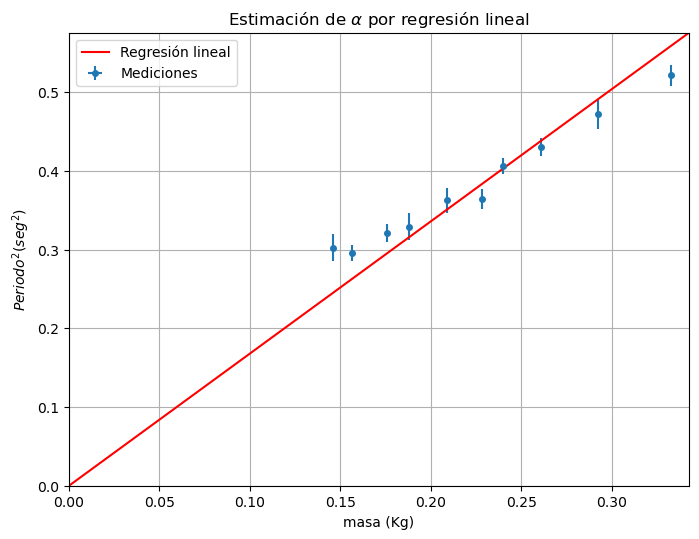

In [314]:
x_min = 0 #min(m)-50
x_max = max(Ms) + 0.01

axis = np.linspace(x_min, x_max, 100)

plt.figure(figsize=(8,6),dpi=100)
plt.errorbar(Ms, Y, xerr=dMs, yerr=dY,marker='o',  markersize=4, linestyle="None", label="Mediciones")
plt.plot(axis, T2(axis, *popt), 'r-', label="Regresión lineal")

plt.axis([x_min, x_max, T2(x_min, *popt), T2(x_max, *popt)])
plt.title('Estimación de $\\alpha$ por regresión lineal')
plt.xlabel('masa (Kg)')
plt.ylabel('$Periodo^2 (seg^2)$')

plt.grid(True)
plt.legend()
plt.show()

In [315]:
popt, pcov = curve_fit(T2, Ms, Y,sigma = dY/Y)
a = popt[0]
da = np.sqrt(pcov[0,0])
print('a  =',  a)
#print('b  =',  b)
print('da =', da)
#print('db =', db)

a  = 1.653189175692821
da = 0.032720055063219594


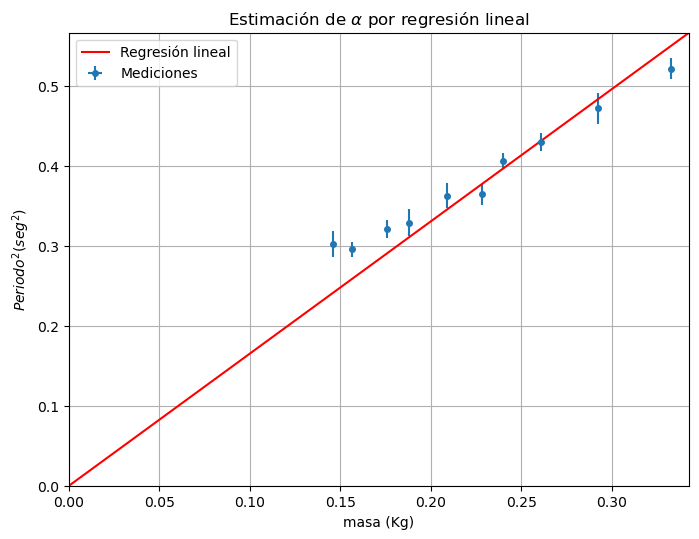

In [316]:
x_min = 0 #min(m)-50
x_max = max(Ms) + 0.01

axis = np.linspace(x_min, x_max, 100)

plt.figure(figsize=(8,6),dpi=100)
plt.errorbar(Ms, Y, xerr = dMs, yerr = dY,marker='o',  markersize = 4, linestyle="None", label="Mediciones")
plt.plot(axis, T2(axis, *popt), 'r-', label="Regresión lineal")

plt.axis([x_min, x_max, T2(x_min, *popt), T2(x_max, *popt)])
plt.title('Estimación de $\\alpha$ por regresión lineal')
plt.xlabel('masa (Kg)')
plt.ylabel('$Periodo^2 (seg^2)$')

plt.grid(True)
plt.legend()
plt.show()

Tenemos que despejar a $k$ de $\alpha$ (a)
$$ \alpha = \frac{4\pi^2}{k} $$
$$ k = \frac{4\pi^2}{\alpha} = \frac{4\pi^2}{a}, \hspace{1cm} \Delta k = \frac{4\pi^2}{\alpha^2} \Delta \alpha $$

In [297]:
k = (4* np.pi**2 ) / a
dk = (4* da * np.pi**2 ) / a**2

print('k: ', k)
print('dk: ',dk)

k:  23.512573673654053
dk:  0.5599850614685064


### *Segunda Parte: Determinacion del coeficiente de amortiguamiento*

Recordar que tenemos las ecuaciones 
$$ F(t) = A e^{-\gamma t} cos(w t  + \phi) + F_0 $$

Primero cargamos los datos del caso amortiguado 

In [317]:
url_amortiguado = 'https://raw.githubusercontent.com/KenetC/myt_verano24/main/DatosTaller3/medicion%20amortiguado'
dfm = pd.read_csv(
      url_amortiguado,  # el primer archivo,
      skiprows=3,  # que ignore las primeras 3 filas
      delimiter="\t",  # separador Tab
      decimal=",",  # coma decimal
      )
dm = dfm.values
t = dm[:,0]
v = dm[:,1]

Hacemos un grafico para ver si estamos con los datos correctos: 

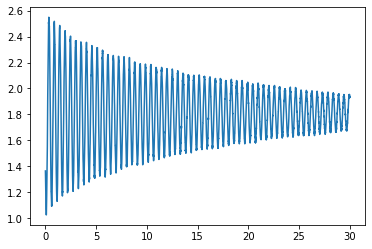

In [318]:
plt.plot(t,v)
plt.show()

Hallamos los picos

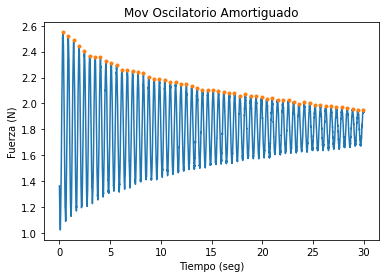

In [319]:
dist = 70 #distancia entre picos
altura = 1 # altura minima de los picos
pos_picos,_ = find_peaks(v,distance=dist, height = altura) #extra posiciones de los picos
tiempo_picos = t[pos_picos] #evaluo las posiciones en los tiempos
fuerza_picos = v[pos_picos] #evaluo las posiciones en las fuerzas
plt.plot(t,v)
plt.plot(tiempo_picos,fuerza_picos,'.')
plt.xlabel('Tiempo (seg)')
plt.ylabel('Fuerza (N)')
plt.title('Mov Oscilatorio Amortiguado')
plt.show()

## **Ajuste Exponencial**

Una vez extraidos los picos, los ploteamos con sus errores: y realizamos el ajuste no lineal


Vamos a definir la funcion exp de la siguiente forma: 
$$ f(x) = A \mathbb{e}^{-g x} + F_0  $$
$x$ es el tiempo en seg 

$A$, $g$,$F_0$ son parametros a estimar

In [320]:
FrecMuestreo = 200 # poner la frecuencia de muestreo

x = tiempo_picos
y = fuerza_picos

dx = np.repeat(1/FrecMuestreo,len(tiempo_picos)) #creo un array de errores iguales
#dF = np.array([0.1,0.1,0.1,0.1,0.1,0.1])
dy = np.repeat(0.01,len(fuerza_picos)) # creo otro array de errores iguales. para pensar que errores van aca


def exponencial(x,A,g,F0): #defino ajuste exponencial
    return A * np.exp(-g * x) + F0

#valores iniciales para el ajuste no lineal
A0 = 1
g0 = 1
F00 = 1
InitialGuess = [A0,g0,F00]

popt, pcov = curve_fit(exponencial, x, y, sigma=dy,
                       absolute_sigma=True,p0 = InitialGuess)#funcion de ajuste
[A,g,F0] = popt #parametros ajustados
er_A,er_g,er_F0 = np.sqrt(np.diag(pcov)) #errores de parametros ajustados

print('A = ', A, '+/-', er_A)
print('gamma = ', g, '+/-', er_g)
print('F0 = ', F0, '+/-', er_F0)

A =  0.615554528534728 +/- 0.00583168214961691
gamma =  0.08263415160554399 +/- 0.0025235425177798794
F0 =  1.9182491647859476 +/- 0.006702134492517736


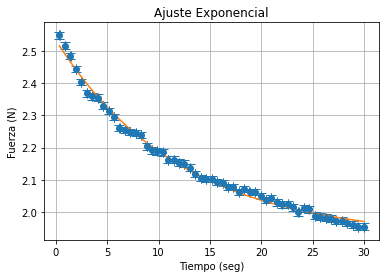

In [321]:
#plt.plot(tiempo_picos,fuerza_picos,'.')
ajuste = exponencial(x,A,g,F0) #evaluo la exponencial en los datos hallados

plt.errorbar(x,y, xerr=dx, yerr=dy, fmt='o', capsize=5)
plt.plot(x,ajuste)
plt.xlabel('Tiempo (seg)')
plt.ylabel('Fuerza (N)')
plt.title('Ajuste Exponencial')
plt.grid(True)
plt.show()

R cuadrado =  0.9932788301492171
Chi cuadrado =  1.7021202202155647


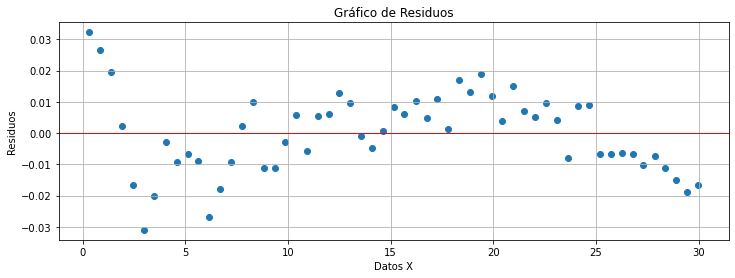

In [322]:
r2 = r_sq(y,ajuste)
chi2 = reduced_chi_sq(y,ajuste,dy,3)
residuos = Residuos(y,ajuste)

print('R cuadrado = ', r2)
print('Chi cuadrado = ',chi2)

plt.figure(figsize=(12, 4))
plt.scatter(x, residuos, marker='o')
plt.axhline(y=0, color='r', linestyle='-', linewidth=1)
plt.xlabel('Datos X')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(True)

## **Ajuste Lineal**

Una vez extraidos, linealizamos y realizamos el ajuste lineal. RECORDAR PROPAGAR ERRORES

Notar que tenemos: 
$$ F(t) = A e^{-\gamma t}  + F_0 $$
$$ F(t) - F_0 = A e^{-\gamma t}  $$
$$ ln(F(t) - F_0)= ln(A e^{-\gamma t}) $$
$$ ln(F(t) - F_0)= ln(A) + ln(e^{-\gamma t}) $$
$$ ln(F(t) - F_0)= ln(A) + -\gamma t  $$

In [323]:
y = np.log(fuerza_picos-F0) #uso el F0 del ajuste anterior para el siguiente

x = tiempo_picos
dx = np.repeat(1/FrecMuestreo,len(tiempo_picos))
#dF = np.array([0.1,0.1,0.1,0.1,0.1,0.1])
dy = (1/(fuerza_picos-F0)) * np.sqrt((0.01)**2+(er_F0)**2) #piensenlo, creo que deberias ir otros errores aca despues lo vemos

def lineal(X,m,b):
    return m*X + b

popt, pcov = curve_fit(lineal, x, y, sigma=dy,
                       absolute_sigma=True,)
[m,b] = popt
er_m,er_b = np.sqrt(np.diag(pcov))

print('Pendiente = ', m, '+/-', er_m)
print('Ordenada = ', b, '+/-', er_b)

Pendiente =  -0.08214303716548271 +/- 0.0010449366165076947
Ordenada =  -0.4849254481846492 +/- 0.008516944671959127


In [330]:
print("A ", np.exp(b))
print("er ",np.exp(b)*er_b)
print()

A  0.615743099819067
er  0.0052442499132996


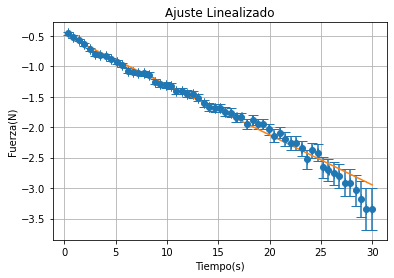

In [324]:
#plt.plot(tiempo_picos,fuerza_picos,'.')
ajuste = lineal(x,m,b)

plt.errorbar(x,y, xerr=dx, yerr=dy, fmt='o', capsize=5)
plt.plot(x,ajuste)
plt.xlabel('Tiempo(s)')
plt.ylabel('Fuerza(N)')
plt.title('Ajuste Linealizado')
plt.grid(True)
plt.show()

R cuadrado =  0.9772341489670758
Chi cuadrado =  1.1194233471684767


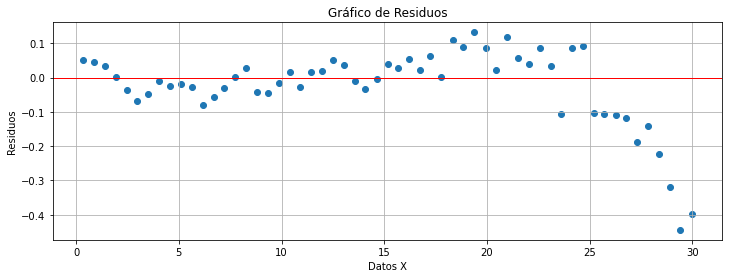

In [194]:
r2 = r_sq(y,ajuste)
chi2 = reduced_chi_sq(y,ajuste,dy,2)
residuos = Residuos(y,ajuste)

print('R cuadrado = ', r2)
print('Chi cuadrado = ',chi2)

plt.figure(figsize=(12, 4))
plt.scatter(tiempo_picos, residuos, marker='o')
plt.axhline(y=0, color='r', linestyle='-', linewidth=1)
plt.xlabel('Datos X')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(True)

## **Ajuste Completo**

Ajusto toda la serie


In [331]:
x = t
y = v

def completo(x,A,g,F0,W,phi):
    return A * np.exp(-g * x)*np.cos(W*x+phi) + F0

#valores iniciales para el ajuste no lineal
A0 = A
g0 = g
F00 = F0
W0 = 1
phi0 = 1
InitialGuess = [A0,g0,F00,W0,phi0]

#agrego limites a los parametros a traves de bounds
# en el primer parentesis pongo los limites inferiores, en el segundo los superiores
popt, pcov = curve_fit(completo, x, y,p0 = InitialGuess,
                       bounds=((-np.inf,-np.inf,-np.inf,-np.inf,0),(np.inf,np.inf,np.inf,np.inf,2*np.pi)))

[A1,g1,F01,W,phi] = popt #
er_A,er_g,er_F0,er_W,er_phi = np.sqrt(np.diag(pcov)) # 

print('A = ', A1, '+/-', er_A)
print('gamma = ', g1, '+/-', er_g)
print('F0 = ', F01, '+/-', er_F0)
print('W = ', W, '+/-', er_W)
print('phi = ', phi, '+/-', er_phi)

A =  -0.49242072576332613 +/- 0.007580133007071276
gamma =  0.04474544797293662 +/- 0.0013274227032872594
F0 =  1.8090529606932544 +/- 0.002002050037845428
W =  11.814915153267522 +/- 0.0013254088956243036
phi =  1.035398881747745e-32 +/- 0.015395620953329973


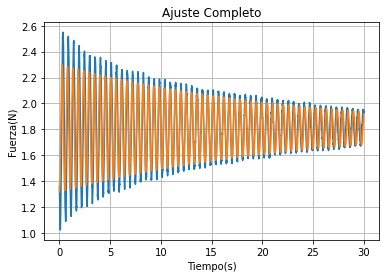

In [332]:
ajuste = completo(x,A1,g1,F01,W,phi) #evaluo la exponencial en los datos hallados

plt.plot(x,y)
plt.plot(x,ajuste)
plt.xlabel('Tiempo(s)')
plt.ylabel('Fuerza(N)')
plt.title('Ajuste Completo')
plt.grid(True)
plt.show()

In [328]:
print('T: ',2* np.pi/W)
print('dT: ',2* np.pi/(W**2) *er_W )

T:  0.5318011365864032
dT:  5.965797874898834e-05


In [ ]:
x = t
y = v

def completo(x,W,phi):
    return A * np.exp(-g * x)*np.cos(W*x+phi) + F0

#valores iniciales para el ajuste no lineal
A0 = A
g0 = g
F00 = F0
W0 = 1
phi0 = 1
InitialGuess = [W0,phi0]#[A0,g0,F00,W0,phi0]

#agrego limites a los parametros a traves de bounds
# en el primer parentesis pongo los limites inferiores, en el segundo los superiores
popt, pcov = curve_fit(completo, x, y,p0 = InitialGuess,
                       bounds=((-np.inf,0),(np.inf,2*np.pi)))

[W,phi] = popt #A1,g1,F01
er_W,er_phi = np.sqrt(np.diag(pcov)) # er_A,er_g,er_F0,

print('A = ', A, '+/-', er_A)
print('gamma = ', g, '+/-', er_g)
print('F0 = ', F0, '+/-', er_F0)
print('W = ', W, '+/-', er_W)
print('phi = ', phi, '+/-', er_phi)